# Adding HITL to a SQL Agent

## Agent with no HITL

Get our sqlite database loaded

In [10]:
from langchain import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///sf-food-inspections-lives.sqlite")
print(db.get_usable_table_names())
print(db.get_table_info(['inspection_records']))

['inspection_records']

CREATE TABLE inspection_records (
	business_id INTEGER NOT NULL, 
	business_name VARCHAR(64) NOT NULL, 
	business_address VARCHAR(50), 
	business_city VARCHAR(13) NOT NULL, 
	business_state VARCHAR(2) NOT NULL, 
	business_postal_code VARCHAR(9), 
	business_latitude FLOAT, 
	business_longitude FLOAT, 
	business_phone_number BIGINT, 
	inspection_id VARCHAR(14) NOT NULL, 
	inspection_date DATE NOT NULL, 
	inspection_score INTEGER, 
	inspection_type VARCHAR(33) NOT NULL, 
	violation_id VARCHAR(21), 
	violation_description VARCHAR(73), 
	risk_category VARCHAR(13)
)

/*
3 rows from inspection_records table:
business_id	business_name	business_address	business_city	business_state	business_postal_code	business_latitude	business_longitude	business_phone_number	inspection_id	inspection_date	inspection_score	inspection_type	violation_id	violation_description	risk_category
10	Tiramisu Kitchen	033 Belden Pl	San Francisco	CA	94104	37.791116	-122.403816	None	10_20140114	2014-01

Create our model

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage

# Build Model
model = ChatOpenAI(temperature=0, streaming=True, model="gpt-5-nano")

# Define system prompt
sys_msg = SystemMessage(content="You are a conversational and friendly sql database assistant." \
"When a customer asks a question you must make a call to the db in order to retrieve the necessary info." \
f"There is one usable table: {db.get_usable_table_names()} - table info: {db.get_table_info(['inspection_records'])}")

Create our db lookup tool

In [12]:
from langchain_core.tools import tool

@tool
def make_db_call(query:str):
    """Look up info from the db to answer the customer's question.

    Args:
        query: str"""
    
    try:
        info = db.run(f"{query}")

        return {"info": info}
    except Exception as e:
        
        return {"error_message": e}
    
# bind tool to model
sql_model = model.bind_tools([make_db_call])

Define MessagesState

In [13]:
from langgraph.graph import MessagesState

class State(MessagesState):
    pass

Create Nodes

In [14]:
def model_node(state:State):

    return {"messages": [sql_model.invoke([sys_msg] + state["messages"])]}

def tool_node(state:State):

    # last message contains param tool_calls, a list of dicts
    tool_call = state["messages"][-1].tool_calls[0]

    # make tool call
    observation = make_db_call.invoke(tool_call["args"])

    tool_message = {"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]}

    return {'messages': tool_message}

Create Graph

In [15]:
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

# Create graph
builder = StateGraph(State)

# Add nodes
builder.add_node("model_node", model_node)
builder.add_node("tools", tool_node)

# Add edges
builder.add_edge(START, "model_node")
builder.add_conditional_edges("model_node", tools_condition)
builder.add_edge("tools", "model_node")

# Compile and view
graph = builder.compile()

# Show
graph.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
        +------------+        
        | model_node |        
        +------------+        
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


Invoke

In [16]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is the average inspection score for restaurants?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the average inspection score for restaurants?
================================== Ai Message ==================================
Tool Calls:
  make_db_call (call_tLBaZcPxN8B5G36nMmRNeLGx)
 Call ID: call_tLBaZcPxN8B5G36nMmRNeLGx
  Args:
    query: SELECT AVG(inspection_score) AS average_inspection_score FROM inspection_records;
================================= Tool Message =================================

{'info': '[(86.13049016485805,)]'}
================================== Ai Message ==================================

The average inspection score for restaurants in the records is about 86.13 (rounded to two decimals). 

If you’d like, I can break this down by city/state, inspection type, or risk category.


## Interruption *between* nodes

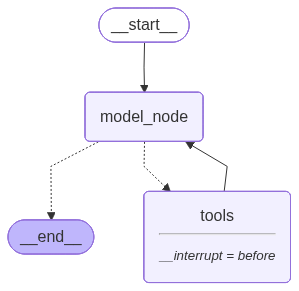

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# view
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [19]:
# Input
initial_input = {"messages": HumanMessage(content="What is the average restaurant inspection score?")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
messages = graph.invoke(initial_input, thread)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the average restaurant inspection score?
================================== Ai Message ==================================
Tool Calls:
  make_db_call (call_qMBMsBwhxfMjIhPLFeItLm4E)
 Call ID: call_qMBMsBwhxfMjIhPLFeItLm4E
  Args:
    query: SELECT AVG(inspection_score) AS average_score FROM inspection_records;


Pass "None" with the same Thread ID to pick up the graph from where we left off

In [20]:
messages = graph.invoke(None, thread)
for m in messages['messages'][2:]:
    m.pretty_print()

================================= Tool Message =================================

{'info': '[(86.13049016485805,)]'}
================================== Ai Message ==================================

The average inspection score in the data is about 86.13 (exact value: 86.13049016485805). 

Would you like this broken down by year, city, or inspection type?


HITL between nodes

In [25]:
# Thread
thread = {"configurable": {"thread_id": "7"}}

# Run the graph until the first interruption
messages = graph.invoke(initial_input, thread)
for m in messages['messages']:
    m.pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (y/[N]): ")

# Check approval
if user_approval.lower() == "y":
    
    # If approved, continue the graph execution
    messages = graph.invoke(None, thread)
    for m in messages['messages'][2:]:
        m.pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

What is the average restaurant inspection score?
================================== Ai Message ==================================
Tool Calls:
  make_db_call (call_JXS12JVCSv6KilUHuHWEVcAS)
 Call ID: call_JXS12JVCSv6KilUHuHWEVcAS
  Args:
    query: SELECT AVG(inspection_score) AS average_score FROM inspection_records
================================= Tool Message =================================

{'info': '[(86.13049016485805,)]'}
================================== Ai Message ==================================

The average inspection score across all records is about 86.13 (exact value: 86.13049016485805). 

If you’d like, I can break this down by city, inspection type, or show the exact count of records used.


## Interruption *within* nodes

Create node with approval step

In [27]:
from langgraph.types import interrupt

def tool_node_with_hitl(state:State):

    # last message contains param tool_calls, a list of dicts
    tool_call = state["messages"][-1].tool_calls[0]

    # make tool call
    observation = make_db_call.invoke(tool_call["args"])

    # interrupt with hitl decision
    decision = interrupt({
            "question": "Append state with the output from the tool call? (y/[N])",
            "sql_query": tool_call["args"],
            "sql_query output": observation
        })
    
    if decision.lower() == 'y':
        # update state with output of tool call
        tool_message = {"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]}
    
    else:
        # don't update state with output of tool call
        tool_message = {"role": "tool", "content" : "Admin chose not to return the answer within the tool message, try again.", "tool_call_id": tool_call["id"]}
    
    return {'messages': tool_message}

Build Graph

In [28]:
# Create graph
builder = StateGraph(State)

# Add nodes
builder.add_node("model_node", model_node)
builder.add_node("tools", tool_node_with_hitl)

# Add edges
builder.add_edge(START, "model_node")
builder.add_conditional_edges("model_node", tools_condition)
builder.add_edge("tools", "model_node")

# Compile and view
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [35]:
# Input
initial_input = {"messages": HumanMessage(content="What is the average restaurant inspection score?")}

# Thread
thread = {"configurable": {"thread_id": "10"}}

# Run the graph until the first interruption
messages = graph.invoke(initial_input, thread)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the average restaurant inspection score?
================================== Ai Message ==================================
Tool Calls:
  make_db_call (call_9XJDJYSjnCdoCbWJ2QwcmmpF)
 Call ID: call_9XJDJYSjnCdoCbWJ2QwcmmpF
  Args:
    query: SELECT AVG(inspection_score) AS average_score FROM inspection_records;


Pass Command(resume="Y") will pick up the graph from where we left off, with our answer being "Y"

In [36]:
from langgraph.types import Command

messages = graph.invoke(Command(resume="n"), thread)
for m in messages['messages'][2:]:
    m.pretty_print()

================================= Tool Message =================================

Admin chose not to return the answer within the tool message, try again.
================================== Ai Message ==================================
Tool Calls:
  make_db_call (call_g08JXAVq8O45KopntMBk6lFh)
 Call ID: call_g08JXAVq8O45KopntMBk6lFh
  Args:
    query: SELECT AVG(inspection_score) AS average_score FROM inspection_records;
